# 04. Modeling experimental replicates

This notebook demonstrates the replicate handling options provided by `estim8`. As a running example, the `SimpleBatch` model introduced in [Notebook 1. Modeling & Simulation](1.%20Modeling%20&%20Simulation.ipynb) is used to create artificial data comprising to experimental replicates with differing conditions. It is shown how to model relations between experimental replicates using a `ParameterMapping` and as well as parameter estimation using the resulting problem.

#### Imports

In [1]:
import sys 
sys.path.append(r'..')

from estim8.models import FmuModel
from estim8.error_models import BaseErrorModel, LinearErrorModel
from estim8 import visualization, datatypes, Estimator, utils
import pandas as pd
import matplotlib.pyplot as plt

# load and init model
SimpleBatchModel = FmuModel(path=r'../tests/test_data/SimpleBatch.fmu')
# import datasheet
data = pd.read_excel(r'SimpleBatch_Data.xlsx', index_col=0, header=[0,1])
data.columns = data.columns.droplevel(1)
data


Time,X,S
0.0,0.176200,NaN
0.1,0.318313,NaN
0.2,0.285270,NaN
0.3,0.218600,NaN
0.4,0.248210,NaN
...,...,...
9.6,4.885956,NaN
9.7,4.807351,NaN
9.8,5.167874,NaN
9.9,5.220779,NaN


## 4.1 Parameter Mapping

In `Estim8`, model replicates are defined using a parameter mapping, which defines a hierarchy tree of global and replicate-specific "local" parameters. 

In [ ]:
# define replicate IDs
replicate_IDs = ['1st', '2nd']

# define an empty list for replicate specific parameters 
mappings = []

# define a different initial substrate concentration for the 1st replicate
mappings.append(utils.ModelHelpers.ParameterMapper(
    global_name='S0',            
    local_name='S0_1st',
    replicate_ID='1st',         
    value=15
    )
    )


# define replicate specific initial biomass concentrations
x0_vals = [
    0.11,   # 1st
    0.085   # 2nd
]

for rID, value in zip(replicate_IDs, x0_vals):
    mappings.append(
        utils.ModelHelpers.ParameterMapper(
            global_name='X0',
            local_name=f"X0_{rID}",
            replicate_ID=rID,
            value=value
        )
    )

parameter_mapping = utils.ModelHelpers.ParameterMapping(
    mappings = mappings,                                # the list of ParameterMappers
    replicate_IDs=replicate_IDs,                        
    default_parameters=SimpleBatchModel.parameters      # default model parameters
)

# display the mapping
parameter_mapping.mapping

local name   value
global name replicate ID                   
Ks          1st                  Ks   0.010
            2nd                  Ks   0.010
S0          1st              S0_1st  15.000
            2nd                  S0  10.000
X0          1st              X0_1st   0.110
            2nd              X0_2nd   0.085
Y_XS        1st                Y_XS   0.350
            2nd                Y_XS   0.350
mu_max      1st              mu_max   0.400
            2nd              mu_max   0.400

The `ParameterMapping` object can be used to get the correct parameter set corresponding to a `replicate_ID` using its class method `replicate_handling`.

Parameters 1st: 
 {'Ks': 0.01, 'S0': 15, 'X0': 0.11, 'Y_XS': 0.35, 'mu_max': 0.4}


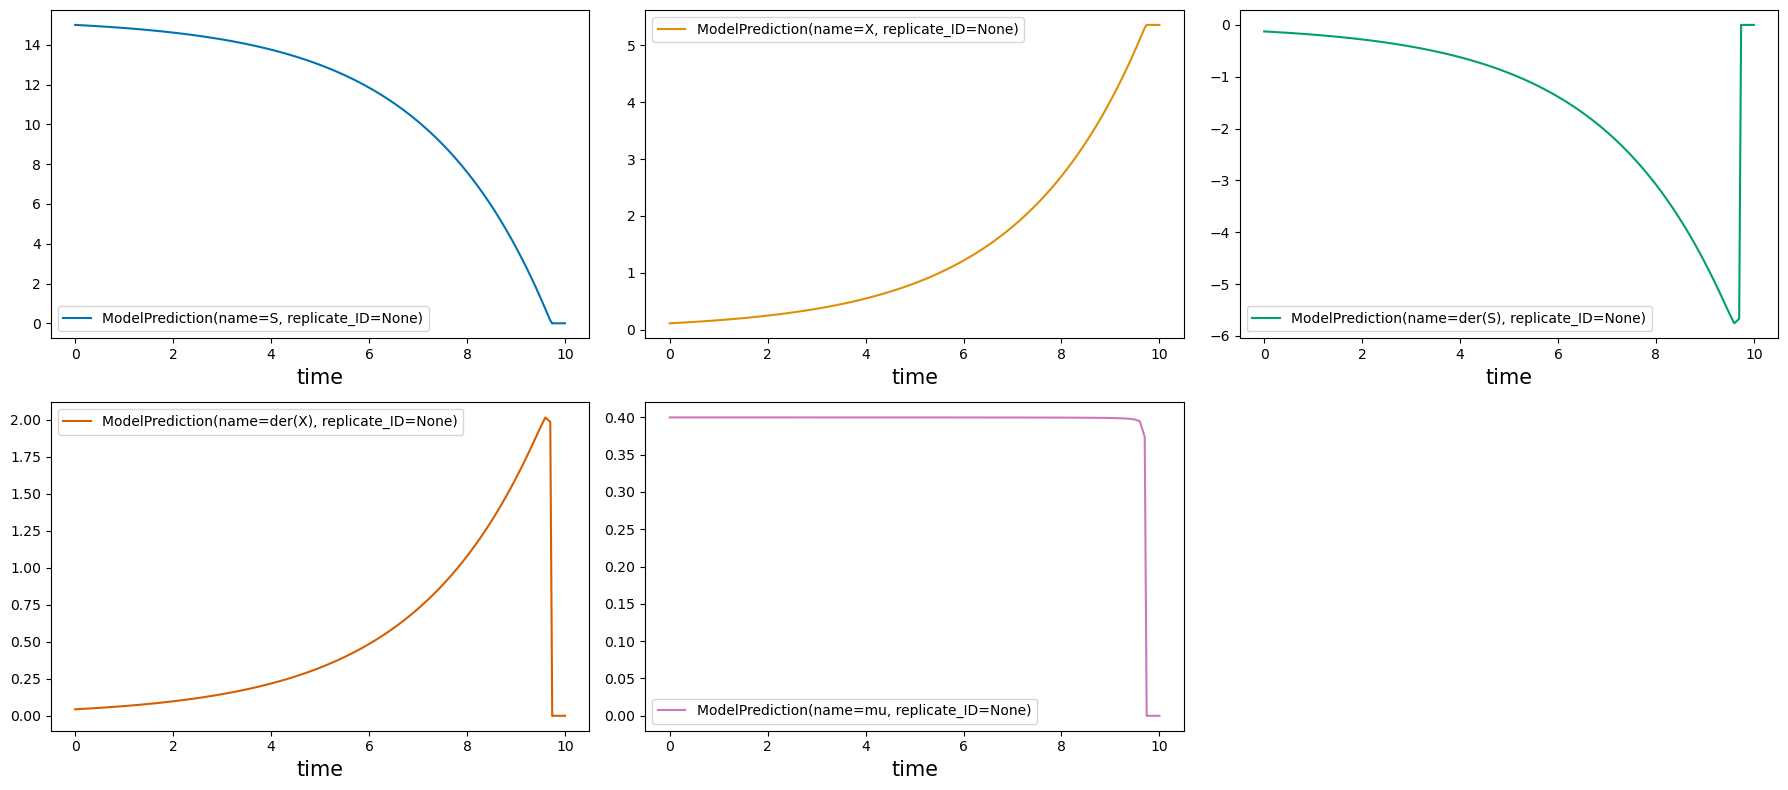

In [3]:
parameters_1st = parameter_mapping.replicate_handling('1st')
print(f'Parameters 1st: \n {parameters_1st}')

# run a simulation with parameters of 1st replicate
sim = SimpleBatchModel.simulate(0, 10, 0.1, parameters=parameters_1st)
_= visualization.plot_simulation(sim)

One can also pass a `dictionary` of parameters different to the default parameters of the `ParameterMapping`, but always refer to the local name of a parameter:

In [ ]:
parameters_2nd = parameter_mapping.replicate_handling(
    replicate_ID='1st',
    parameters= {
        'S0': 1,          # will not be used, as it should be named as the local parameter "S0_1st" defined above
        'X0_1st': 0.15,   # correct reference to local parameter
        'mu_max': 0.4
        }
)
parameters_2nd

{'Ks': 0.01, 'S0': 15, 'X0': 0.15, 'Y_XS': 0.35, 'mu_max': 0.4}

## 4.2 Parameter estimation with replicates

### 4.2.1 Artificial noisy data
The `SimpleBatch` model introduced in [Notebook 1](1.%20Modeling%20&%20Simulation.ipynb) is used to create an artificial data set of two replicates based on the `ParameterMapping` defined above. 

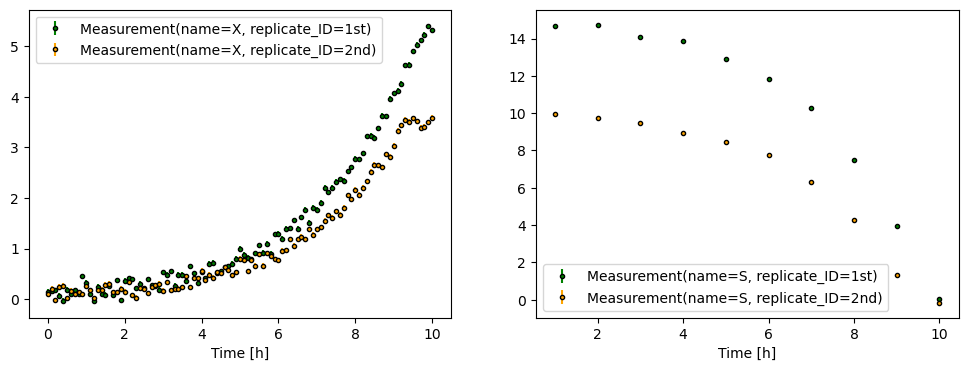

In [ ]:
# define a function to create an artificial experiment
def make_experiment(parameters, model: FmuModel, original_data: pd.DataFrame, error_model: BaseErrorModel = LinearErrorModel(), rID: str = datatypes.Constants.SINGLE_ID, resample=4):
    simulation = model.simulate(t0=0, t_end=10, stepsize=0.1, parameters=parameters)

    measurements = []
    for obs in original_data.columns:
        model_prediction = simulation[obs]
        # get timepoints of measurements from datesheet above
        timepoints = original_data[obs].dropna().index
        values = model_prediction.interpolate(timepoints)
        # get noisy values by resampling the data according to erro models distribution
        for _ in range(resample):
            values = error_model.get_sampling(values, 1)[0]

        measurements.append(
            datatypes.Measurement(
                name = model_prediction.name,
                timepoints=timepoints,
                values=values,
                error_model=error_model,
                replicate_ID=rID
            )
        )
    return datatypes.Experiment(measurements, replicate_ID=rID)


# create noisy data
artificial_data = dict()
for r_ID in replicate_IDs:
    replicate_parameters = parameter_mapping.replicate_handling(
        replicate_ID=r_ID
    )

    artificial_data[r_ID] = make_experiment(parameters=replicate_parameters, original_data=data, model=SimpleBatchModel, error_model=LinearErrorModel(offset=0.05), rID=r_ID)

# plot data
fig, axes = plt.subplots(
    ncols=2,
    nrows=1,
    figsize=(12, 4)
)

for (r_ID, experiment), color in zip(artificial_data.items(), ['green', 'orange']):
    for ax, measurement in zip(axes, experiment.measurements):
        visualization.plot_measurement(ax=ax, measurement=measurement, color=color, ecolor=color)
        ax.set_xlabel('Time [h]')
        ax.legend()

Defining unknown parameters and their bounds is done analogously to the example above, where we passed a  dictionary of parameters to the `replicate_handling` function above by referring to a __local__ name. 

In [6]:
display(parameter_mapping.mapping)

bounds = {
    'X0_1st': [0.05, 0.2],
    'X0_2nd': [0.05, 0.2],
    'S0_1st': [1, 20],
    'mu_max': [0.2, 0.7]
}

local name   value
global name replicate ID                   
Ks          1st                  Ks   0.010
            2nd                  Ks   0.010
S0          1st              S0_1st  15.000
            2nd                  S0  10.000
X0          1st              X0_1st   0.110
            2nd              X0_2nd   0.085
Y_XS        1st                Y_XS   0.350
            2nd                Y_XS   0.350
mu_max      1st              mu_max   0.400
            2nd              mu_max   0.400

### 4.2.2 Parallelized paramter estimation


c:\Users\Tobia\miniforge-pypy3\envs\testim8\lib\site-packages\scipy\optimize\_differentialevolution.py:487: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


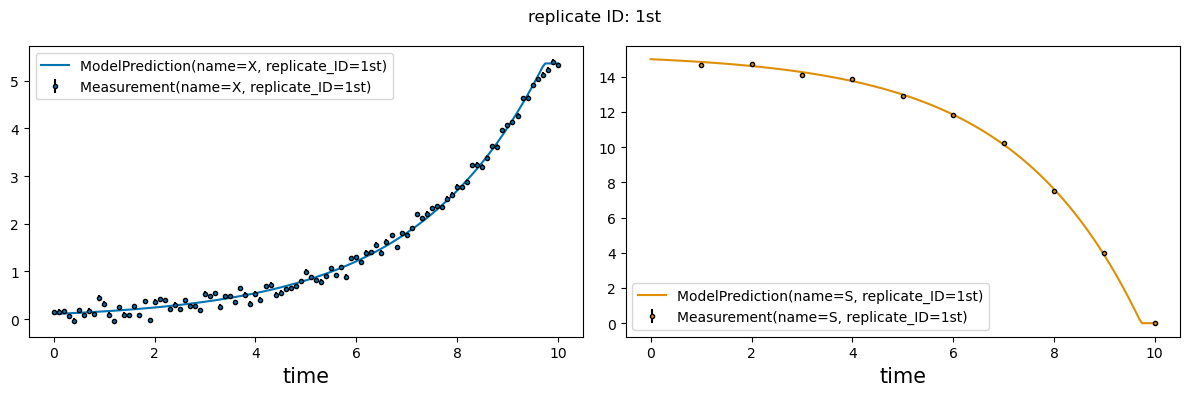

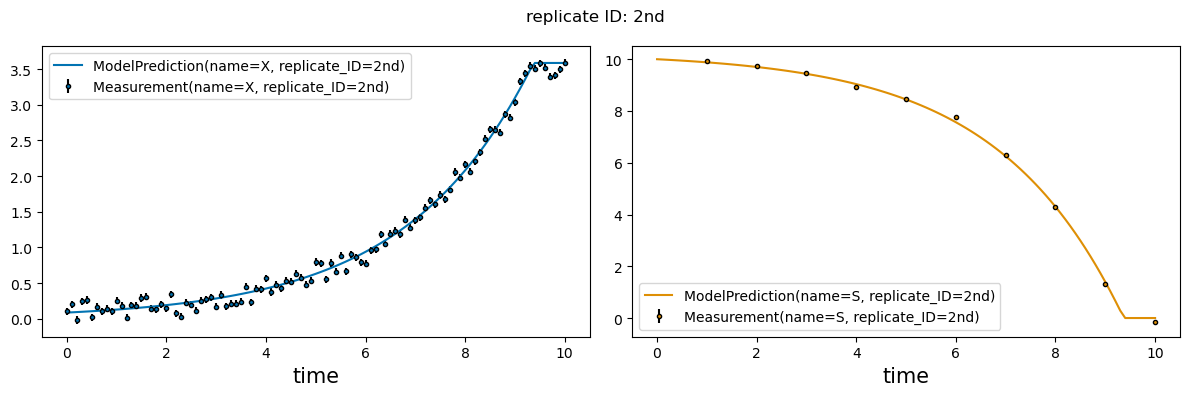

In [7]:
# create an Estimator instance
estimator = Estimator(
    data=artificial_data,
    model=SimpleBatchModel,
    parameter_mapping=parameter_mapping,   # the parameter mapping 
    bounds=bounds,
    t = [0, 10, 0.1]            # t_start, t_end, stepsize_solver for simulation
)

# estimate
estimates, est_info = estimator.estimate(
    method='de',
    max_iter=1000,
    n_jobs=4,
)

_ = visualization.plot_estimates(estimates=estimates, estimator=estimator, only_measured=True)